# Character based text Generation

#### Tell colab what version to use

In [2]:
%tensorflow_version 2.x

## Import standard Libraries

In [3]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from tensorflow.keras import Model

# Load data

Convert to string

In [6]:
shakespeare = tfds.load('tiny_shakespeare')['train']
shakespeare = next(iter(shakespeare))
shakespeare = shakespeare['text'].numpy().decode('utf-8')
print(shakespeare[:100])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You


# Prepare the dataset

We cen use python dictonaries to convert our chars to IDs or we use keras' StringLookup layer.
Using the StringLookup layer is more convenient, because we don't have to convert back and forth between tensors and numpy arrays to loop through.  
But the StringLookup layer also adds two additional vocabolary entries (' ', and '[UNK]') that we have to be aware of when translating predicted IDs back to text, as we don't want to sample those entries.

## Using dict

In [348]:
# Function to get a string out of a tensor with char IDs
def text_from_ids(id_tensor):
    return ''.join([id2char[char] for char in id_tensor.numpy().flatten()])

In [328]:
# Create vocabulary
vocab = set(shakespeare)

# Use dictionaries to translate characters to IDs and back
char2id = {char:id for id, char in enumerate(vocab)}
id2char = {id:char for char,id in char2id.items()}

# Translate the shakespeare text to IDs
text_ids = [char2id[char] for char in shakespeare]

# Test 
print(text_ids[:20])

[40, 63, 36, 5, 27, 7, 39, 63, 27, 63, 41, 16, 64, 28, 18, 51, 16, 53, 2, 36]


### Create the sequences

In [349]:
SEQ_LEN = 20 #@param ["20", "50", "100"] {type:"raw"}

# Create dataset of sequences
ids_dataset = tf.data.Dataset.from_tensor_slices(text_ids)
# 'drop_remainder' drops the last batch if it's smaller than batch_size
seq_dataset = ids_dataset.batch(batch_size=SEQ_LEN+1, 
                                drop_remainder=True)

# Look at first sequence
for seq in seq_dataset.take(1):
    print(text_from_ids(seq))

First Citizen:
Before


### Create dataset of (input, target)-pairs

In [331]:
BATCH_SIZE = 64 #@param ["32", "64", "128"] {type:"raw"}
BUFFER_SIZE = 1000 #@param ["1000", "10000", "100000"] {type:"raw"}

# Create Datasets and make sure minibatches all have same size
dataset = seq_dataset.map(lambda seq: (seq[:-1],seq[1:]),
                          num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Shuffle the data
dataset = dataset.shuffle(BUFFER_SIZE)

# Create minibatches
dataset = dataset.batch(BATCH_SIZE,drop_remainder=True)

# Prefetch the data
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

dataset

<PrefetchDataset shapes: ((64, 20), (64, 20)), types: (tf.int32, tf.int32)>

## Using StringLookup

In [135]:
# Function to get a string out of a tensor with char IDs
def text_from_ids(id_tensor):
    return tf.strings.reduce_join(id2char(id_tensor)).numpy().decode('utf-8')

In [252]:
from tensorflow.keras.layers.experimental.preprocessing import StringLookup

# Create a tensor containing the text as a list of characters
text_tensor = tf.strings.unicode_split(shakespeare, 'UTF-8')

# Use the StringLookup layer to translate characters to IDs and back
char2id = StringLookup(vocabulary=list(set(shakespeare)))
id2char = StringLookup(vocabulary=char2id.get_vocabulary(), invert=True)

# Create vocabulary (use the StringLookup vocabulary because that contains padding and unknown characters at indeces '0' and '1')
vocab = char2id.get_vocabulary()

# Translate the shakespeare text to IDs
text_ids = char2id(text_tensor)

# Test 
print(text_ids)

tf.Tensor([42 65 38 ... 18 38 18], shape=(1003854,), dtype=int64)


### Create the sequences

In [255]:
SEQ_LEN = 20 #@param ["20", "50", "100"] {type:"raw"}

# Create dataset of sequences
ids_dataset = tf.data.Dataset.from_tensor_slices(text_ids)
# 'drop_remainder' drops the last batch if it's smaller than batch_size
seq_dataset = ids_dataset.batch(batch_size=SEQ_LEN+1, 
                                drop_remainder=True)

# Look at first sequence
for seq in seq_dataset.take(1):
    print(text_from_ids(seq))

First Citizen:
Before


### Create dataset of (input, target)-pairs

In [256]:
BATCH_SIZE = 64 #@param ["32", "64", "128"] {type:"raw"}
BUFFER_SIZE = 1000 #@param ["1000", "10000", "100000"] {type:"raw"}

# Create Datasets and make sure minibatches all have same size
dataset = seq_dataset.map(lambda seq: (seq[:-1],seq[1:]),
                          num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Shuffle the data
dataset = dataset.shuffle(BUFFER_SIZE)

# Create minibatches
dataset = dataset.batch(BATCH_SIZE,drop_remainder=True)

# Prefetch the data
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

dataset

<PrefetchDataset shapes: ((64, 20), (64, 20)), types: (tf.int64, tf.int64)>

# Inspect the dataset

In [350]:
for input, target in dataset.take(1):
    print(f'Input-target pair:\n{input[0], target[0]}')
    print(f'\nInput:  {text_from_ids(input[0])}\nTarget:  {text_from_ids(target[0])}')

Input-target pair:
(<tf.Tensor: shape=(20,), dtype=int32, numpy=
array([35, 56, 24, 56, 35, 30,  7, 63, 64, 24, 16, 16, 24, 34,  7, 61,  7,
       35, 59,  5], dtype=int32)>, <tf.Tensor: shape=(20,), dtype=int32, numpy=
array([56, 24, 56, 35, 30,  7, 63, 64, 24, 16, 16, 24, 34,  7, 61,  7, 35,
       59,  5, 27], dtype=int32)>)

Input:  madam; indeed, I mus
Target:  adam; indeed, I must


# Define RNN cell

We define our weight matrizes as simple dense layers without activation.  
It's important to not use a bias in the input layer.

In [335]:
class RNN_cell(Model):
    def __init__(self, state_size):
        super(RNN_cell, self).__init__()
        # W_xh
        self.input_weights = tf.keras.layers.Dense(units=state_size,
                                                   activation=None,
                                                   use_bias = False,
                                                   name='Input_layer'
                                                   )
        # W_hh+b_h
        self.hidden_weights = tf.keras.layers.Dense(units=state_size,
                                                    activation=None,
                                                    name='Hidden_layer'
                                                    )
        
    def call(self, x_t, h_t):
        # Computing the new hidden state
        # h_t = sigmoid(x_t*W_xh + h_t*W_hh+b_h)
        h_t = tf.keras.activations.sigmoid(self.input_weights(x_t)+self.hidden_weights(h_t))        
        return h_t

## Inspect RNN cell

In [337]:
cell = RNN_cell(128)
_ = cell(tf.ones((BATCH_SIZE,64)),
         tf.zeros((BATCH_SIZE,128))
        )
cell.summary()

Model: "rnn_cell_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_layer (Dense)          multiple                  8192      
_________________________________________________________________
Hidden_layer (Dense)         multiple                  16512     
Total params: 24,704
Trainable params: 24,704
Non-trainable params: 0
_________________________________________________________________


# Define RNN

In [338]:
class RNN(Model):
    def __init__(self, state_size, vocab_size, embedding_size):
        super(RNN, self).__init__()
        self.state_size = state_size

        self.readin_layer = tf.keras.layers.Embedding(input_dim=vocab_size,
                                                      output_dim=embedding_size,
                                                      input_length=SEQ_LEN,
                                                      name='ReadIn_layer'
                                                      )
        
        self.RNNcell = RNN_cell(self.state_size)

        self.output_layer = tf.keras.layers.Dense(units=vocab_size,
                                                  activation='softmax',
                                                  name='Readout_layer'
                                                 )
          
    def call(self, seq):
        t = tf.constant(0)
        # Store the outputs of each timestep in a TensorArray
        outputs = tf.TensorArray(tf.float32, size=SEQ_LEN)

        seq = self.readin_layer(seq)

        # First timestep; reset hidden state
        h_t = tf.zeros((BATCH_SIZE,self.state_size))

        h_t = self.RNNcell(seq[:,t], h_t)
        
        output = self.output_layer(h_t)
        outputs = outputs.write(0,output)
        t += 1
        
        # Use tensorflow conditional tf.less for graph mode
        while tf.less(t, SEQ_LEN):
            h_t = self.RNNcell(seq[:,t], h_t)
            output = self.output_layer(h_t)
            outputs = outputs.write(t,output)
            t += 1
        
        # Transpose the TensorArray to get shape (BATCH_SIZE, Timesteps, output_size)
        rnn_out = tf.transpose(outputs.stack(),perm=[1,0,2])
        return rnn_out

## Inspect RNN

We sample one character for each timestep using the softmax output as distribution.

In [354]:
rnn = RNN(128, len(vocab), 64)
for input, target in dataset.take(1):
    rnn_out = rnn(input)
    print(f'Input: {text_from_ids(input[0])}\n')
    predicted_ids = tf.random.categorical(rnn_out[0], num_samples=1)
    print(f'Prediction: {text_from_ids(predicted_ids)}\n')

rnn.summary()

Input:  at first,
Which you

Prediction: QhMdPJi3TaD3d!T:?Zwo

Model: "rnn_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ReadIn_layer (Embedding)     multiple                  4160      
_________________________________________________________________
rnn_cell_14 (RNN_cell)       multiple                  24704     
_________________________________________________________________
Readout_layer (Dense)        multiple                  8385      
Total params: 37,249
Trainable params: 37,249
Non-trainable params: 0
_________________________________________________________________


# Define the training process

#### Function to plot the models performance

In [355]:
from IPython.display import clear_output

def visualize_progress(num_epochs, epoch, train_losses):
    clear_output(wait=True)
    fig = plt.figure(figsize=(15,5))
    plt.xlim((0,num_epochs))
    plt.plot(train_losses,label='Training')
    plt.ylabel('Loss',fontsize=24)
    plt.xlabel('Epochs',fontsize=24)
    plt.title(f'Epoch: {epoch+1}', fontweight='bold', fontsize=30)
    plt.xticks(np.arange(0,num_epochs,2))
    plt.legend()
    plt.show() 

In [356]:
def train_model(model, dataset, loss_function, optimizer, num_epochs):
    running_average_factor = 0.95

    # Initialize lists for later visualization.
    train_losses = []
    
    # Train loop for num_epochs epochs.
    for epoch in range(num_epochs):
            
        # Training
        running_average_loss = 0
        for input_seq, target_seq in dataset:
            train_loss = train_step(model, input_seq, target_seq, loss_function, optimizer)
            running_average_loss = running_average_factor * running_average_loss  + (1 - running_average_factor) * train_loss

        train_losses.append(running_average_loss.numpy())

        # Testing
        
        visualize_progress(num_epochs, epoch, train_losses)
            
        # Display loss and accuracy for current epoch    
        print(f'Epoch: __ {epoch+1}')
        print('Train loss: ',running_average_loss.numpy())

# Define training

In [357]:
@tf.function
def train_step(model, input_seq, target_seq, loss_function, optimizer):
    with tf.GradientTape() as tape:
        pred = model(input_seq)
        loss = loss_function(target_seq, pred)
        gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

# Train LSTM

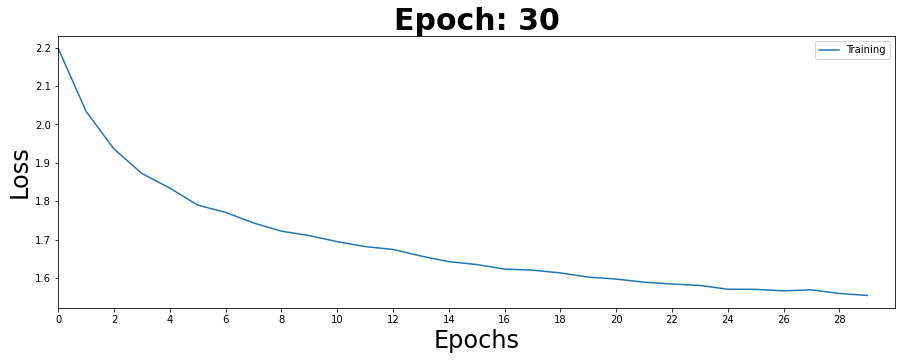

Epoch: __ 30
Train loss:  1.5548457
CPU times: user 11min 27s, sys: 1min 16s, total: 12min 43s
Wall time: 7min 44s


In [358]:
%%time
tf.keras.backend.clear_session()

learning_rate = 0.001
state_size = 256
embedding_size = 128
epochs = 30

# Initialize the loss
# We use SparseCategoricalCrossentropy here
# This way we don't have to onehot encode our targets and can just use the charID and the softmax prediction to calculate the loss
loss_function = tf.keras.losses.SparseCategoricalCrossentropy()

# Initialize the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate)

# Initialize model
rnn = RNN(state_size, len(vocab), embedding_size)
train_model(
    model = rnn,
    dataset = dataset,
    num_epochs = epochs,
    loss_function = loss_function,
    optimizer = optimizer
)

In [281]:
rnn.summary()

Model: "rnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ReadIn_layer (Embedding)     multiple                  17152     
_________________________________________________________________
rnn_cell (RNN_cell)          multiple                  1311744   
_________________________________________________________________
Readout_layer (Dense)        multiple                  68675     
Total params: 1,397,571
Trainable params: 1,397,571
Non-trainable params: 0
_________________________________________________________________


# Test one sequence

In [361]:
for input, target in dataset.take(1):
    rnn_out = rnn(input)
    print(f'Input: {text_from_ids(input[0])}\n')
    predicted_ids = tf.random.categorical(rnn_out[0], num_samples=1)
    print(f'Prediction: {text_from_ids(predicted_ids)}\n')

Input: ade doubt but Rome w

Prediction: ZNmRq&':FDK
jbB.,gtN

tf.Tensor(1.9795345, shape=(), dtype=float32)
